In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [2]:
import json

from typing import List

In [3]:
from src.settings import TrainerConfig, SubjectConfig, FeatureConfig
from src.trainer import Trainer
from src.config import timescales

# Config

In [4]:
config_dir = ".temp/config/"
config_subject_dir = ".temp/config/subject/"
config_train_dir = ".temp/config/train/"
config_feature_dir = ".temp/config/feature"

if not os.path.exists(config_subject_dir):
    os.makedirs(config_dir)

if not os.path.exists(config_train_dir):
    os.makedirs(config_train_dir)

if not os.path.exists(config_feature_dir):
    os.makedirs(config_feature_dir)

In [5]:
feature_dir = ".temp/feature/"

bert_feature_path = os.path.join(feature_dir, "timescales_BERT_all.npz")
mbert_feature_path = os.path.join(feature_dir, "timescales_mBERT_all.npz")

moten_feature_path = os.path.join(feature_dir, "m_ll.npz")

sensory_feature_train_path = os.path.join(feature_dir, "features_trn_NEW.hdf")
sensory_feature_test_path = os.path.join(feature_dir, "features_val_NEW.hdf")

In [6]:
lm_feature_type = "BERT"
subject_id = "07"
task = "reading"

In [7]:
# On RA
sub_config = SubjectConfig()

# sub_config.sub_id = subject_id 

# sub_config.sub_fmri_train_path = (
#     f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_reading_fmri_data_trn.hdf"
# )
# sub_config.sub_fmri_test_path = (
#     f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_reading_fmri_data_val.hdf"
# )
# sub_config.sub_fmri_mapper_path = (
#     f"/media/data/dataset/timescale/fmri/deniz2019/subject{subject_id}_mappers.hdf"
# )
# sub_config.task = "reading"

In [8]:
# On Matar
def get_sub_config(sub_id: str, task: str, dir: str):
    sub_config = SubjectConfig()
    
    sub_config.sub_id = sub_id  

    sub_config.sub_fmri_train_path = (
        f"/mnt/raid/bling/data/fmri/deniz2019/subject{sub_id}_{task}_fmri_data_trn.hdf"
    )
    sub_config.sub_fmri_test_path = (
        f"/mnt/raid/bling/data/fmri/deniz2019/subject{sub_id}_{task}_fmri_data_val.hdf"
    )
    sub_config.sub_fmri_mapper_path = (
        f"/mnt/raid/bling/data/fmri/deniz2019/subject{sub_id}_mappers.hdf"
    )
    sub_config.task = task

    if not os.path.exists(dir):
        os.makedirs(dir)

    # save to json
    with open(
        dir + f"subject-{sub_config.sub_id}-{sub_config.task}.json", "w"
    ) as fp:
        json.dump(sub_config.__dict__, fp, indent=4)

In [9]:
get_sub_config("07", "reading", config_subject_dir)
get_sub_config("07", "listening", config_subject_dir)

In [8]:
def generate_feature_config(
    lm_feature_type: str = lm_feature_type,
    timescales: List[str] = timescales,
    motens: List[str] = ["7"],
    ):

    f_dir = config_feature_dir
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)

    feature_config = FeatureConfig()
    feature_config.timescale = timescales
    
    feature_config.lm_feature_type = lm_feature_type
    if lm_feature_type == "BERT":
        feature_config.lm_feature_path = bert_feature_path
    elif lm_feature_type == "mBERT":
        feature_config.lm_feature_path = mbert_feature_path
    
    feature_config.sensory_feature_train_paths = sensory_feature_train_path
    feature_config.sensory_feature_test_paths = sensory_feature_test_path
    feature_config.sensory_features = ["numletters", "numwords"]

    feature_config.motion_energy_feature_paths = moten_feature_path
    feature_config.motion_energy_features = motens

    # saving config
    timescale_str = "all_timescales" if len(timescales) > 1 else "".join(timescales)
    motens_str = "".join(motens)
    
    fn = os.path.join(f_dir, lm_feature_type+ "-"+ timescale_str +"-"+motens_str+ "-feature_config.json")
    with open(fn, "w") as fp:
        json.dump(feature_config.__dict__, fp, indent=4)

In [9]:
generate_feature_config(lm_feature_type="BERT", motens=['6'])
generate_feature_config(lm_feature_type="mBERT", motens=['6'])

In [12]:

def generate_trainer_config(
    n_iter: int = 1000, 
    fn :str = "trainer_config",
    result_save_dir: str = ".temp/result/",):
    
    # dir = os.path.join(config_train_dir, lm_feature_type.lower())
    # if not os.path.exists(dir):
    #     os.makedirs(dir)
    # Trainer Config
    trainer_config = TrainerConfig()

    trainer_config.backend = "torch_cuda"
     
    trainer_config.fit_on_mask = True
    
    trainer_config.n_iter = n_iter
    trainer_config.n_targets_batch = 4096
    trainer_config.n_targets_batch_refit = 2048

    trainer_config.result_save_dir = result_save_dir

    # trainer_config.hyperparams_save_dir = os.path.join(result_save_dir, "hyperparams")
    # trainer_config.model_save_dir = os.path.join(result_save_dir, "models")
    # trainer_config.stats_save_dir = f".temp/results/{lm_feature_type.lower()}/stats"
    
    # saving config
    fn = os.path.join(config_train_dir, f"{fn}.json")
    with open(fn, "w") as fp:
        json.dump(trainer_config.__dict__, fp, indent=4)

In [13]:
generate_trainer_config()
generate_trainer_config(fn="trainer_config_shorttime", n_iter=10)

# Training

# Test training

In [26]:
train_config_path = ".temp/config/train/trainer_config_shorttime.json"
feature_config_path = ".temp/config/feature/BERT-2_4_words-7-feature_config.json"
feature_config_path = ".temp/config/feature/BERT-all_timescales-7-feature_config.json"
sub_config_path = ".temp/config/subject/subject-07-reading.json"

In [15]:
# # load config
# with open(train_config_path) as f:
#     train_config = json.load(f)
# train_config = TrainerConfig(**train_config)

# with open(feature_config_path) as f:
#     feature_config = json.load(f)
# feature_config = FeatureConfig(**feature_config)

# with open(sub_config_path) as f:
#     sub_config = json.load(f)
# sub_config = SubjectConfig(**sub_config)


In [27]:
trainer = Trainer(sub_config_path, feature_config_path, train_config_path)

In [28]:
# train_config.n_iter = 10
trainer.train()

Fitting model...
[........................................] 100% | 44.45 sec | 10 random sampling with cv | 
training took 53.75325798988342 seconds


In [29]:
trainer.refit_and_evaluate()

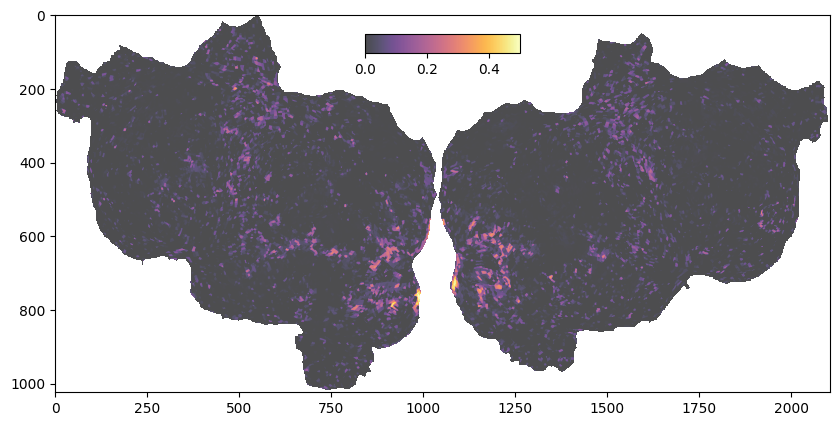

In [30]:
trainer.plot(feature_index=-1, is_corr=True)

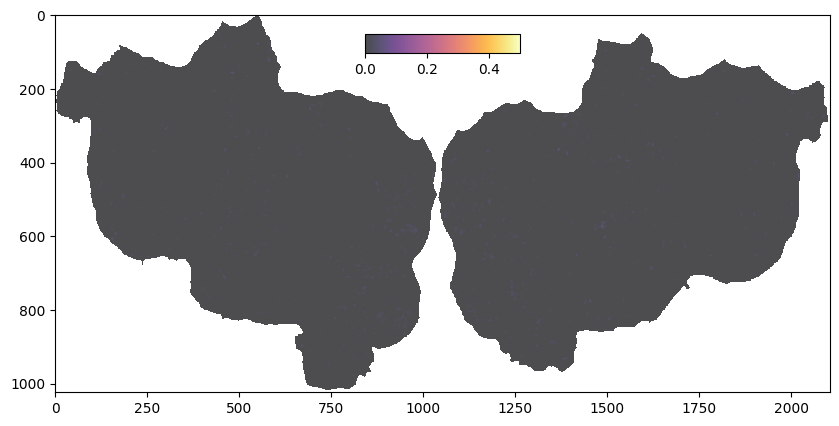

In [31]:
trainer.plot(feature_index=0, is_corr=True)

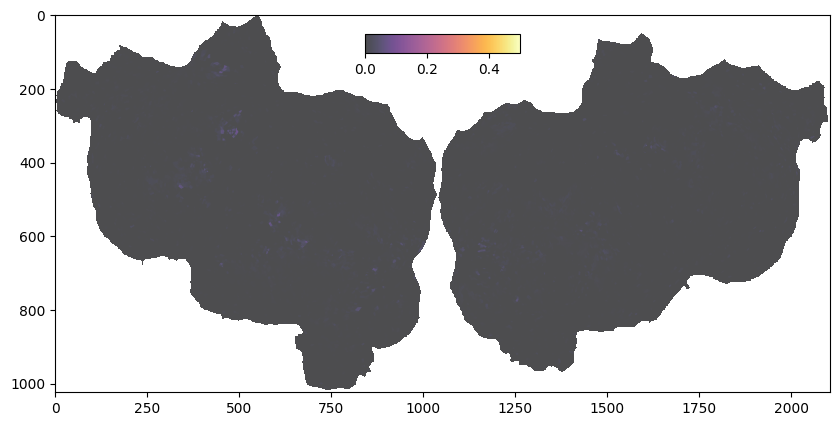

In [32]:
trainer.plot(feature_index=1, is_corr=True)

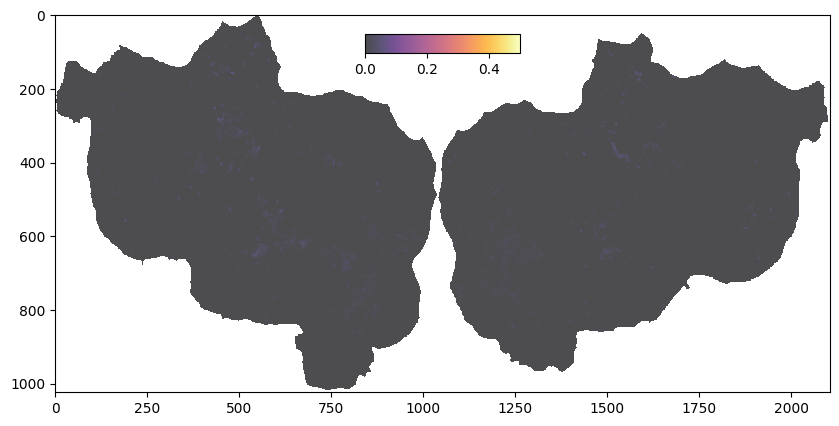

In [33]:
trainer.plot(feature_index=2, is_corr=True)

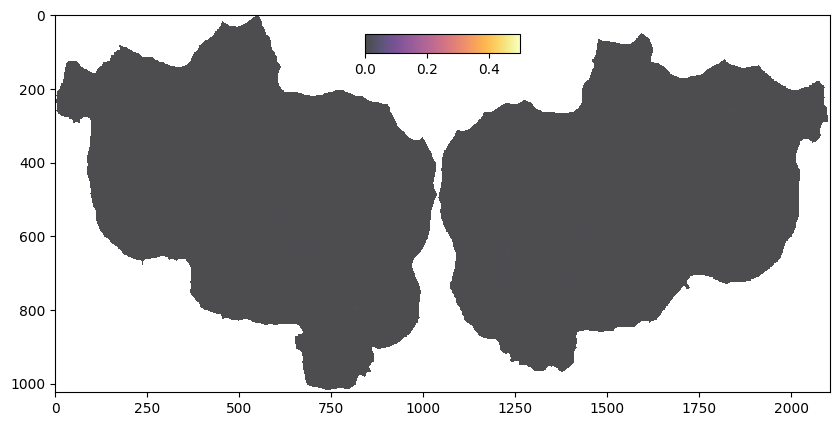

In [42]:
trainer.plot(feature_index=3, is_corr=True)

In [36]:
trainer.train_feature_info

[{'name': 'lm_2_4_words', 'size': 9984},
 {'name': 'lm_4_8_words', 'size': 9984},
 {'name': 'lm_8_16_words', 'size': 9984},
 {'name': 'lm_16_32_words', 'size': 9984},
 {'name': 'lm_32_64_words', 'size': 9984},
 {'name': 'lm_64_128_words', 'size': 9984},
 {'name': 'lm_128_256_words', 'size': 9984},
 {'name': 'lm_256+ words', 'size': 9984},
 {'name': 'numletters', 'size': 1},
 {'name': 'numwords', 'size': 1},
 {'name': 'motion energy : 7', 'size': 6555}]